# 데이터 수집

- 제무재표 수집 함수 생성

- dart사이트 기업모니터링 페이지를 통해서 재무제표 크롤링

# DGB

## DGB 제무재표 수집

In [75]:
import pandas as pd
import re
import requests

def FS_crawler(code):
    
    # encparam 값을 추출 정규 표현식(대소문자 무시)
    re_enc = re.compile("encparam: '(.*)'", re.IGNORECASE)
    # id 값을 추출 정규 표현식 (대소문자 무시)
    re_id = re.compile("id: '([a-zA-Z0-9]*)' ?", re.IGNORECASE)
    
    # 회사 정보 페이지 URL에 회사 코드를 포함하여 생성
    url = "http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd={}".format(code)
    
    html = requests.get(url).text
    encparam = re_enc.search(html).group(1)
    encid = re_id.search(html).group(1)
    
    # ajax를 사용하여 재무 데이터를 가져오기 위한 URL 생성
    url = "http://companyinfo.stock.naver.com/v1/company/ajax/cF1001.aspx?cmp_cd={}&fin_typ=0&freq_typ=A&encparam={}&id={}".format(code, encparam, encid)
    headers = {"Referer": "HACK"}# Referer 헤더를 "HACK"으로 설정하여 요청
    # 해당 URL의 HTML 소스 코드 가져오기
    html = requests.get(url, headers=headers).text
    # print(html)  # 디버깅을 위해 HTML 출력할 수 있음
    
    dfs = pd.read_html(html)
    # 분기분기컨센서스보기 추출
    df = dfs[1]['분기분기컨센서스보기']
    # 주요재무정보 인덱스로 설정
    df.index = dfs[1]['주요재무정보'].values.flatten()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int) # 정수값으로 출력

    return df

In [ ]:
dgb = FS_crawler("139130")
dgb = dgb.T.iloc[1:-1]
dgb = dgb.reset_index()
dgb['Quarter'] = dgb['index'].apply(lambda x: '2024Q1' if '03' in x else '2024Q2' if '06' in x else None)

dgb

C:\Users\campus4D042\AppData\Local\Temp\ipykernel_31168\1540154221.py:26: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(html)


,index,매출액,영업이익,영업이익(발표기준),세전계속사업이익,당기순이익,당기순이익(지배),당기순이익(비지배),자산총계,부채총계,...,자본유보율,EPS(원),PER(배),BPS(원),PBR(배),현금DPS(원),현금배당수익률,현금배당성향(%),발행주식수(보통주),Quarter
0,2024/03 (IFRS연결),20535,1585,1585,1549,1130,1117,12,962767,900741,...,635,660,4,35274,0,0,0,0,169145833,2024Q1
1,2024/06 (IFRS연결),19437,335,335,333,308,382,-75,950305,888024,...,638,226,5,35475,0,0,0,0,169145833,2024Q2


## DGB 주가데이터 수집

In [94]:
import FinanceDataReader as fdr
import numpy as np

dgb_df = fdr.DataReader('139130').reset_index()
dgb_df['Date'] = pd.to_datetime(dgb_df['Date'])
dgb_df = dgb_df.dropna()
dgb_df['Quarter'] = pd.to_datetime(dgb_df['Date']).dt.to_period('Q')

dgb_df

,Date,Open,High,Low,Close,Volume,Change,Quarter
1,2011-06-08,16294,16583,15233,15523,1399354,-0.047318,2011Q2
2,2011-06-09,15570,15956,14172,14751,3374344,-0.049733,2011Q2
3,2011-06-10,14654,15908,14606,15523,2061255,0.052335,2011Q2
4,2011-06-13,15185,15570,14896,15185,711045,-0.021774,2011Q2
5,2011-06-14,15281,15619,15185,15330,585748,0.009549,2011Q2
...,...,...,...,...,...,...,...,...
3297,2024-10-28,8240,8250,8120,8240,466654,0.002433,2024Q4
3298,2024-10-29,8170,8210,8100,8160,474032,-0.009709,2024Q4
3299,2024-10-30,8180,8180,8090,8140,482687,-0.002451,2024Q4
3300,2024-10-31,8150,8180,8070,8170,640376,0.003686,2024Q4


## DGB데이터 병합

In [97]:
dgb_df['Quarter'] = dgb_df['Quarter'].astype(str)
dgb['Quarter'] = dgb['Quarter'].astype(str)

# 병합 작업 수행
dgb_df = pd.merge(dgb_df, dgb, on='Quarter', how='left')
dgb_df = dgb_df[dgb_df['Quarter'].str.startswith('2024')]

dgb_df

,Date,Open,High,Low,Close,Volume,Change,Quarter,index,매출액,...,부채비율,자본유보율,EPS(원),PER(배),BPS(원),PBR(배),현금DPS(원),현금배당수익률,현금배당성향(%),발행주식수(보통주)
3097,2024-01-02,8420,8490,8300,8410,589136,-0.009423,2024Q1,2024/03 (IFRS연결),20535.0,...,1452.0,635.0,660.0,4.0,35274.0,0.0,0.0,0.0,0.0,169145833.0
3098,2024-01-03,8360,8430,8350,8410,353303,0.000000,2024Q1,2024/03 (IFRS연결),20535.0,...,1452.0,635.0,660.0,4.0,35274.0,0.0,0.0,0.0,0.0,169145833.0
3099,2024-01-04,8410,8410,8280,8290,488774,-0.014269,2024Q1,2024/03 (IFRS연결),20535.0,...,1452.0,635.0,660.0,4.0,35274.0,0.0,0.0,0.0,0.0,169145833.0
3100,2024-01-05,8270,8270,8110,8140,518115,-0.018094,2024Q1,2024/03 (IFRS연결),20535.0,...,1452.0,635.0,660.0,4.0,35274.0,0.0,0.0,0.0,0.0,169145833.0
3101,2024-01-08,8150,8150,8060,8080,287153,-0.007371,2024Q1,2024/03 (IFRS연결),20535.0,...,1452.0,635.0,660.0,4.0,35274.0,0.0,0.0,0.0,0.0,169145833.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3296,2024-10-28,8240,8250,8120,8240,466654,0.002433,2024Q4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3297,2024-10-29,8170,8210,8100,8160,474032,-0.009709,2024Q4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3298,2024-10-30,8180,8180,8090,8140,482687,-0.002451,2024Q4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3299,2024-10-31,8150,8180,8070,8170,640376,0.003686,2024Q4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
dgb_df.to_excel('DGB.xlsx', index = False)

# 카카오뱅크

## 카카오뱅크 제무재표 수집

In [98]:
# 323410

kakao = FS_crawler("323410")
kakao = kakao.T.iloc[1:-1]
kakao = kakao.reset_index()
kakao['Quarter'] = kakao['index'].apply(lambda x: '2024Q1' if '03' in x else '2024Q2' if '06' in x else None)

kakao

C:\Users\campus4D042\AppData\Local\Temp\ipykernel_31168\1540154221.py:26: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(html)


,index,매출액,영업이익,영업이익(발표기준),세전계속사업이익,당기순이익,당기순이익(지배),당기순이익(비지배),자산총계,부채총계,...,자본유보율,EPS(원),PER(배),BPS(원),PBR(배),현금DPS(원),현금배당수익률,현금배당성향(%),발행주식수(보통주),Quarter
0,2024/03 (IFRS별도),7179,1484,1484,1479,1112,1112,0,603974,542459,...,158,233,36,12913,2,0,0,0,476921137,2024Q1
1,2024/06 (IFRS별도),7341,1698,1698,1600,1202,1202,0,610304,547410,...,164,252,24,13202,1,0,0,0,476926137,2024Q2


## 카카오뱅크 주가데이터 수집

In [99]:
import FinanceDataReader as fdr
import numpy as np

kakao_df = fdr.DataReader('323410').reset_index()
kakao_df['Date'] = pd.to_datetime(kakao_df['Date'])
kakao_df = kakao_df.dropna()
kakao_df['Quarter'] = pd.to_datetime(kakao_df['Date']).dt.to_period('Q')

kakao_df

,Date,Open,High,Low,Close,Volume,Change,Quarter
1,2021-08-09,69800,89100,69000,78500,44833696,0.124642,2021Q3
2,2021-08-10,81800,85600,68000,71400,26495122,-0.090446,2021Q3
3,2021-08-11,71200,77500,68100,74400,21592734,0.042017,2021Q3
4,2021-08-12,73600,75400,72700,73800,5878196,-0.008065,2021Q3
5,2021-08-13,73500,78600,73500,76600,10907993,0.037940,2021Q3
...,...,...,...,...,...,...,...,...
789,2024-10-28,21650,22200,21650,22200,426169,0.025404,2024Q4
790,2024-10-29,21950,22200,21750,22200,279524,0.000000,2024Q4
791,2024-10-30,22150,22500,21900,22100,376915,-0.004505,2024Q4
792,2024-10-31,21950,21950,21600,21650,425955,-0.020362,2024Q4


## 카카오뱅크 데이터 병합

In [ ]:
kakao_df['Quarter'] = kakao_df['Quarter'].astype(str)
kakao['Quarter'] = kakao['Quarter'].astype(str)

kakao_df = pd.merge(kakao_df, kakao, on='Quarter', how='left')
kakao_df = kakao_df[kakao_df['Quarter'].str.startswith('2024')]

kakao_df

,Date,Open,High,Low,Close,Volume,Change,Quarter,index,매출액,...,부채비율,자본유보율,EPS(원),PER(배),BPS(원),PBR(배),현금DPS(원),현금배당수익률,현금배당성향(%),발행주식수(보통주)
589,2024-01-02,28150,28350,27250,28000,907014,-0.017544,2024Q1,2024/03 (IFRS별도),7179.0,...,881.0,158.0,233.0,36.0,12913.0,2.0,0.0,0.0,0.0,476921137.0
590,2024-01-03,27550,27750,27100,27200,830611,-0.028571,2024Q1,2024/03 (IFRS별도),7179.0,...,881.0,158.0,233.0,36.0,12913.0,2.0,0.0,0.0,0.0,476921137.0
591,2024-01-04,26800,27050,26200,26200,763853,-0.036765,2024Q1,2024/03 (IFRS별도),7179.0,...,881.0,158.0,233.0,36.0,12913.0,2.0,0.0,0.0,0.0,476921137.0
592,2024-01-05,26250,26550,25750,25900,559464,-0.011450,2024Q1,2024/03 (IFRS별도),7179.0,...,881.0,158.0,233.0,36.0,12913.0,2.0,0.0,0.0,0.0,476921137.0
593,2024-01-08,25950,26300,25850,25950,467742,0.001931,2024Q1,2024/03 (IFRS별도),7179.0,...,881.0,158.0,233.0,36.0,12913.0,2.0,0.0,0.0,0.0,476921137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,2024-10-28,21650,22200,21650,22200,426169,0.025404,2024Q4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
789,2024-10-29,21950,22200,21750,22200,279524,0.000000,2024Q4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
790,2024-10-30,22150,22500,21900,22100,376915,-0.004505,2024Q4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
791,2024-10-31,21950,21950,21600,21650,425955,-0.020362,2024Q4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
kakao_df.to_excel('카카오뱅크.xlsx', index = False)

# 주요 재무 비율 시각화

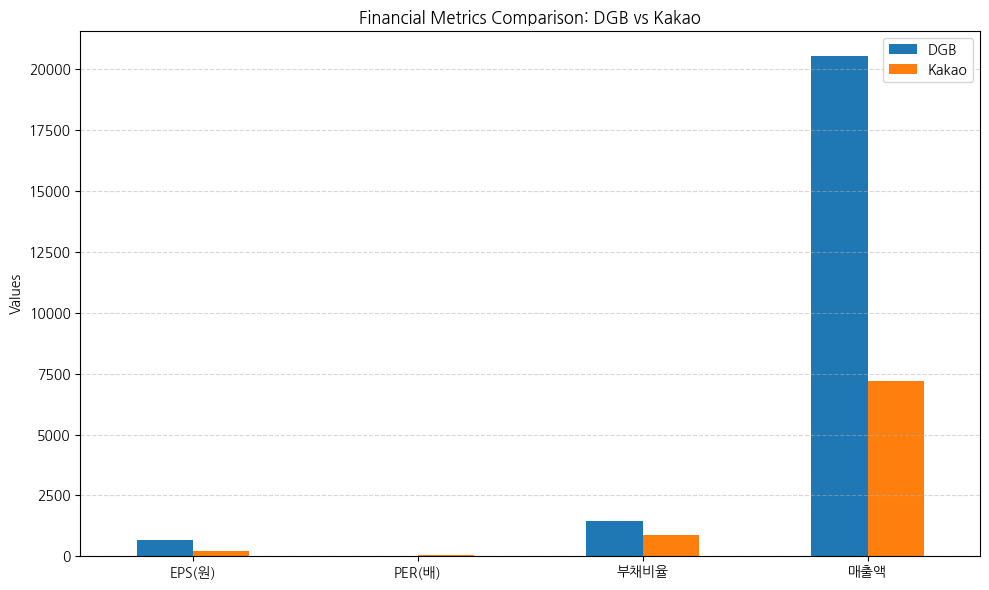

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

metrics = ['EPS(원)', 'PER(배)', '부채비율', '매출액']
dgb_financials = dgb_df[metrics].iloc[0]
kakao_financials = kakao_df[metrics].iloc[0]

comparison_df = pd.DataFrame({
    'DGB': dgb_financials,
    'Kakao': kakao_financials
})

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Financial Metrics Comparison: DGB vs Kakao')
plt.ylabel('Values')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


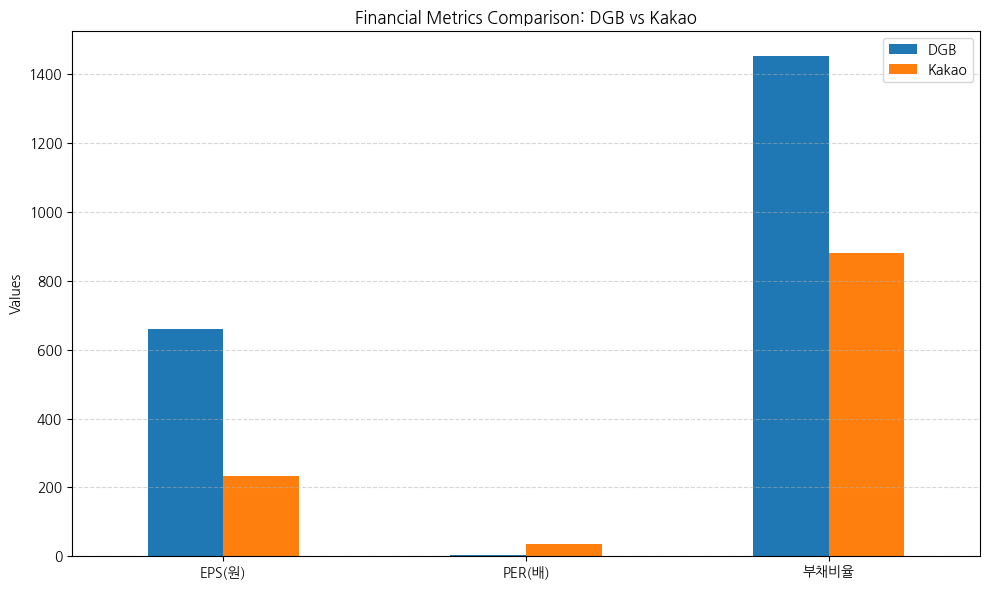

In [112]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

metrics = ['EPS(원)', 'PER(배)', '부채비율']
dgb_financials = dgb_df[metrics].iloc[0]
kakao_financials = kakao_df[metrics].iloc[0]

comparison_df = pd.DataFrame({
    'DGB': dgb_financials,
    'Kakao': kakao_financials
})

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Financial Metrics Comparison: DGB vs Kakao')
plt.ylabel('Values')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


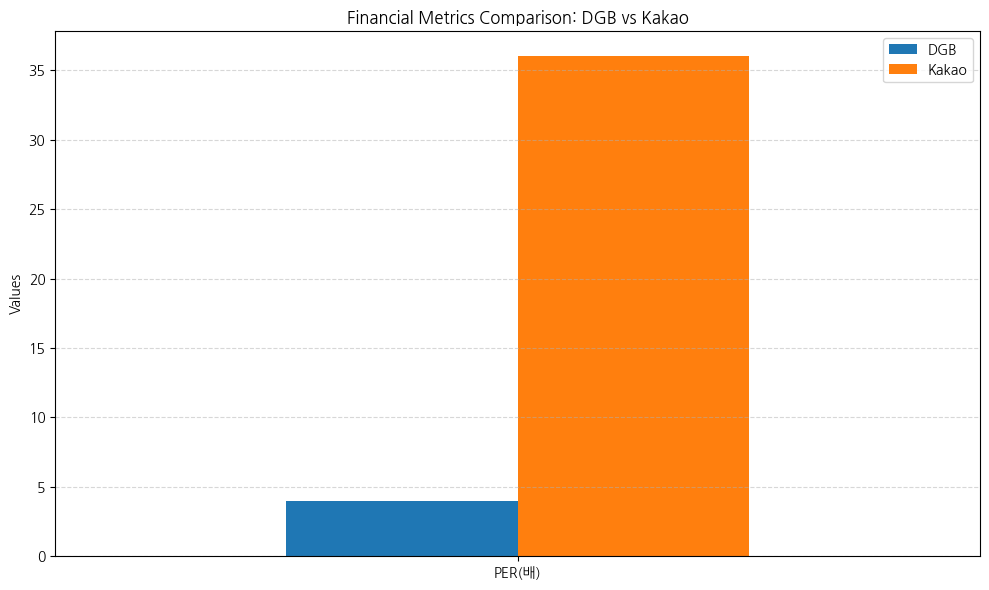

In [113]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

metrics = ['PER(배)']
dgb_financials = dgb_df[metrics].iloc[0]
kakao_financials = kakao_df[metrics].iloc[0]

comparison_df = pd.DataFrame({
    'DGB': dgb_financials,
    'Kakao': kakao_financials
})

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Financial Metrics Comparison: DGB vs Kakao')
plt.ylabel('Values')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 상대적인 수치를 통한 시각화
- 절대적인 수치로 파악하기 힘든 부분을 보기위함

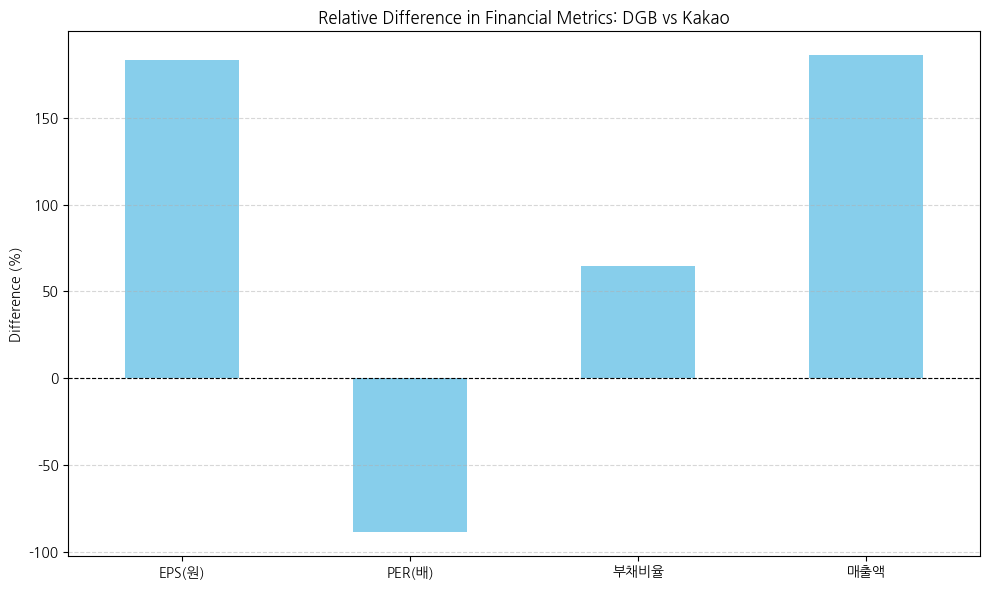

In [114]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 데이터 준비
metrics = ['EPS(원)', 'PER(배)', '부채비율', '매출액']
dgb_financials = dgb_df[metrics].iloc[0]
kakao_financials = kakao_df[metrics].iloc[0]

comparison_df = pd.DataFrame({
    'DGB': dgb_financials,
    'Kakao': kakao_financials
})

# 상대적 차이 계산 (DGB 기준)
relative_diff = ((comparison_df['DGB'] - comparison_df['Kakao']) / comparison_df['Kakao']) * 100

# 시각화
relative_diff.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Relative Difference in Financial Metrics: DGB vs Kakao')
plt.ylabel('Difference (%)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # 기준선 추가
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 주가 추이와 거래량을 시각화

## # 기술적 지표 계산 함수 생성

In [108]:
# 기술적 지표 계산 함수
def calculate_technical_indicators(df):
    # 이동평균 (MA)
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA60'] = df['Close'].rolling(window=60).mean()
    df['MA120'] = df['Close'].rolling(window=120).mean()

    # 상대강도지수 (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df

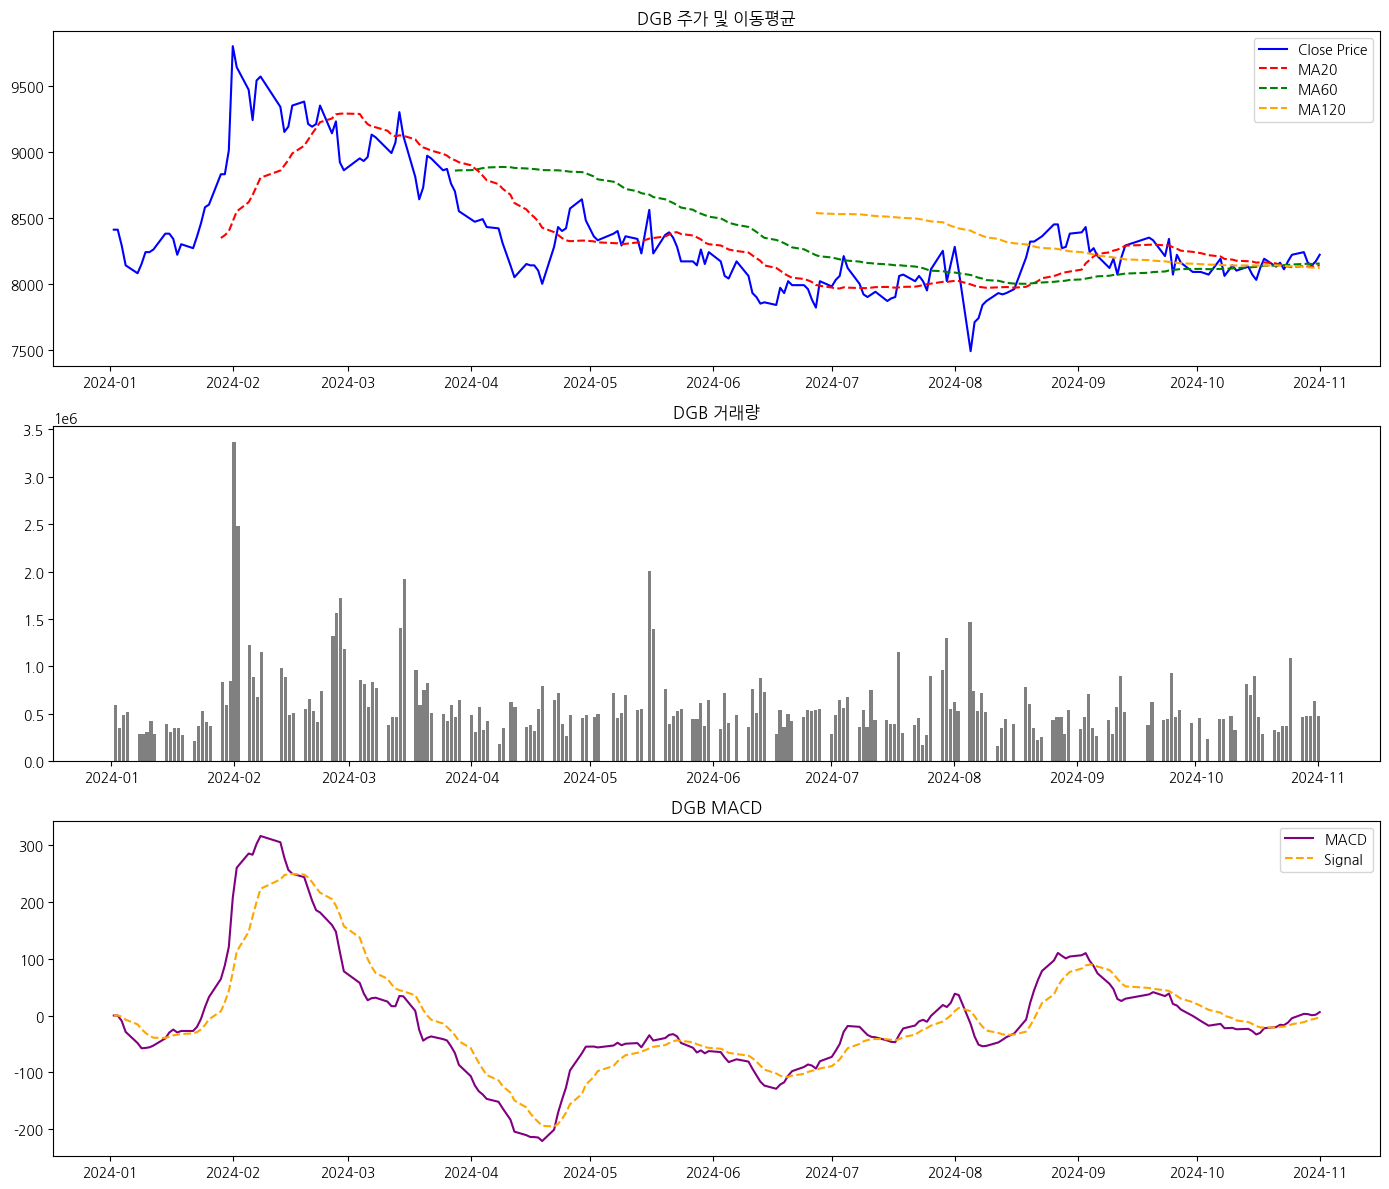

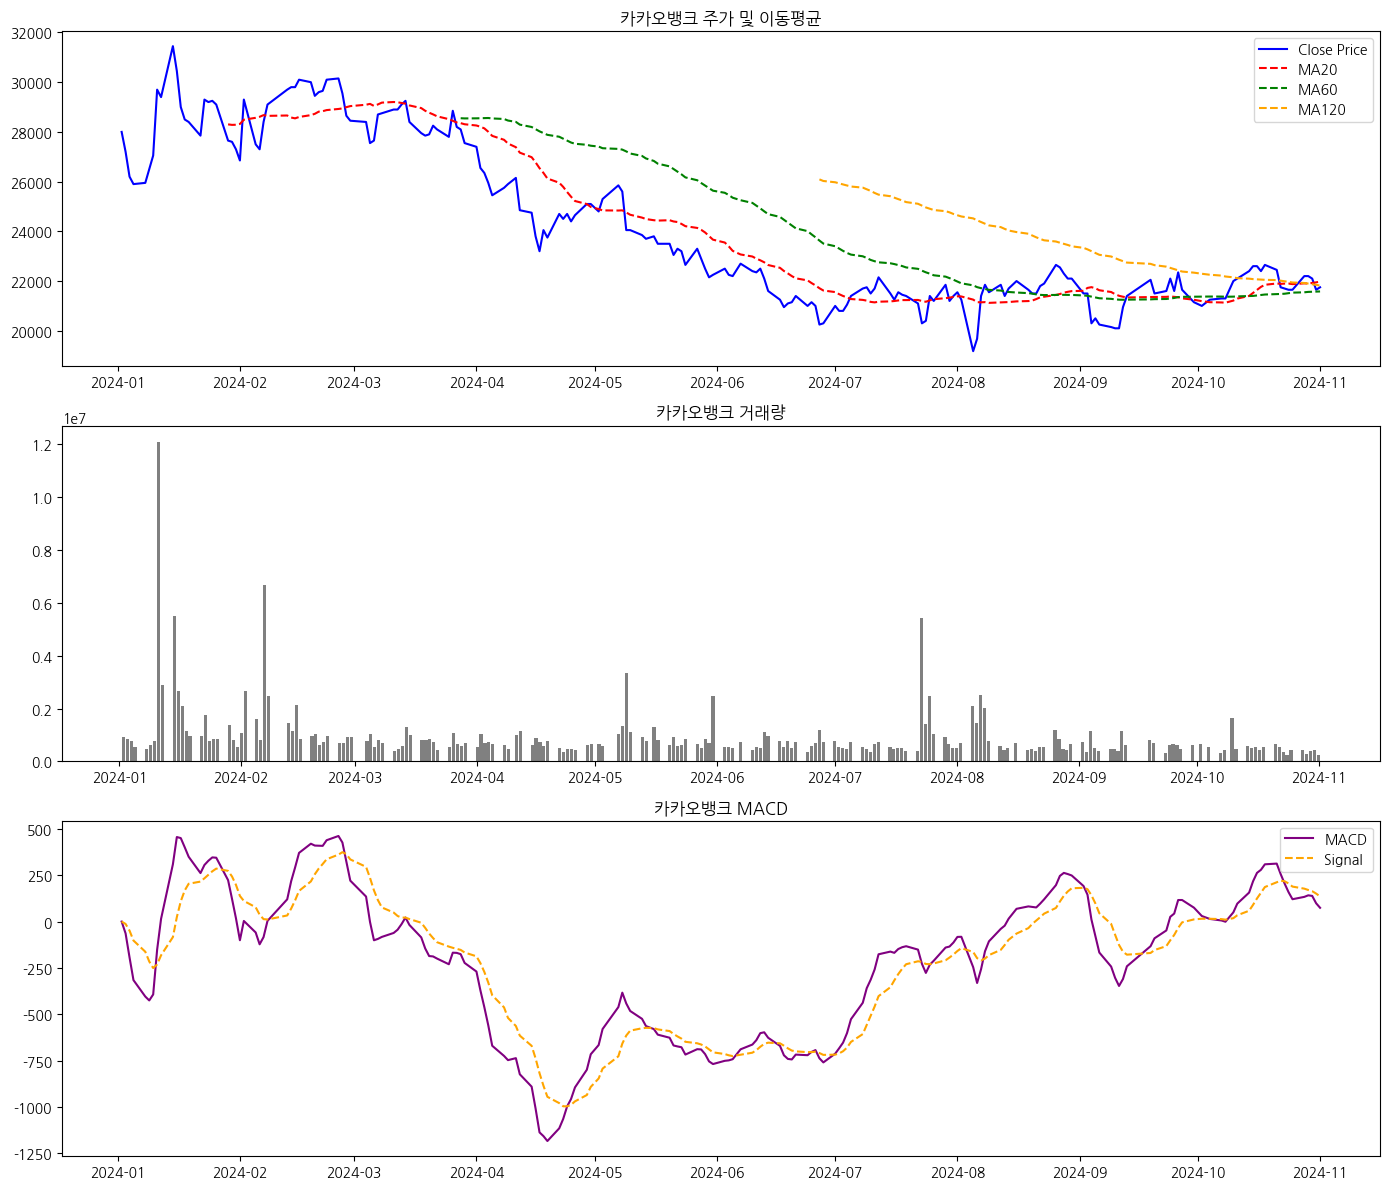

In [ ]:
# 날짜 설정
dgb_df['Date'] = pd.to_datetime(dgb_df['Date'])
kakao_df['Date'] = pd.to_datetime(kakao_df['Date'])

# 날짜를 인덱스로 설정
dgb_df.set_index('Date', inplace=True)
kakao_df.set_index('Date', inplace=True)


# 기술적 지표 추가
dgb_df = calculate_technical_indicators(dgb_df)
kakao_df = calculate_technical_indicators(kakao_df)

# 시각화: 주가 추이 및 거래량
def plot_stock_analysis(df, title):
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))

    # 주가 및 이동평균
    axes[0].plot(df.index, df['Close'], label='Close Price', color='blue')
    axes[0].plot(df.index, df['MA20'], label='MA20', color='red', linestyle='--')
    axes[0].plot(df.index, df['MA60'], label='MA60', color='green', linestyle='--')
    axes[0].plot(df.index, df['MA120'], label='MA120', color='orange', linestyle='--')
    axes[0].set_title(f'{title} 주가 및 이동평균')
    axes[0].legend()

    # 거래량
    axes[1].bar(df.index, df['Volume'], color='grey')
    axes[1].set_title(f'{title} 거래량')

    # MACD
    axes[2].plot(df.index, df['MACD'], label='MACD', color='purple')
    axes[2].plot(df.index, df['Signal'], label='Signal', color='orange', linestyle='--')
    axes[2].set_title(f'{title} MACD')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# 주가 시각화 실행
plot_stock_analysis(dgb_df, 'DGB')
plot_stock_analysis(kakao_df, '카카오뱅크')


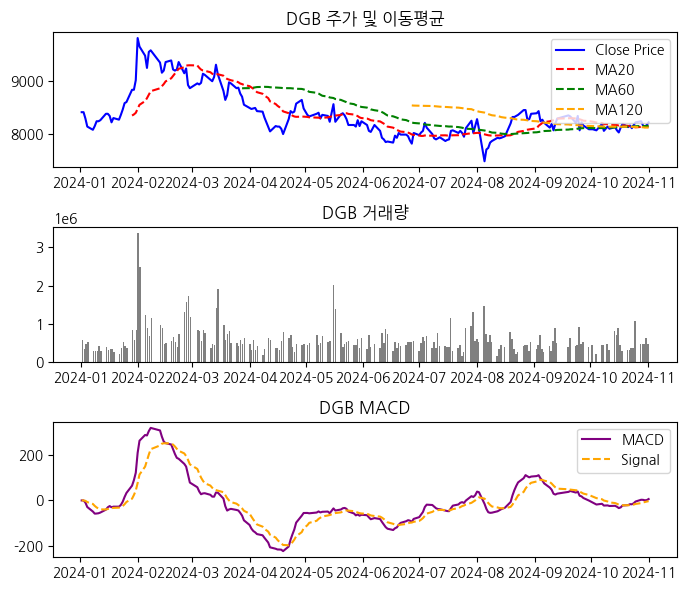

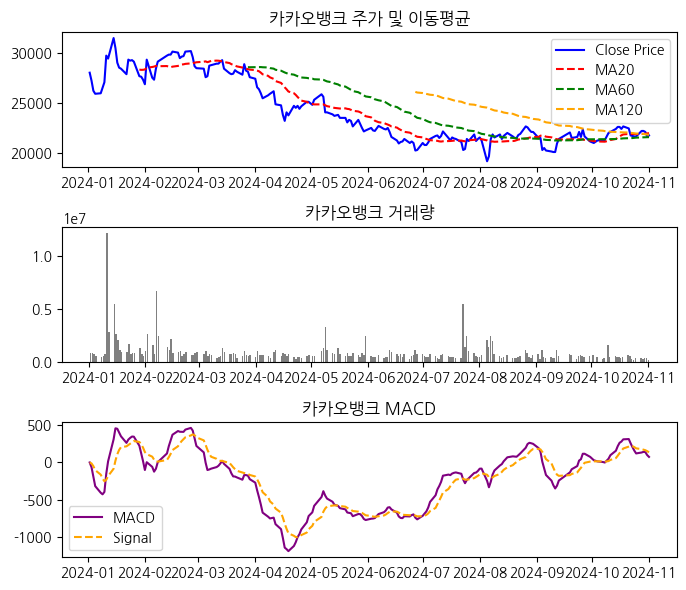

In [122]:
# 기술적 지표 추가
dgb_df = calculate_technical_indicators(dgb_df)
kakao_df = calculate_technical_indicators(kakao_df)

# 시각화: 주가 추이 및 거래량
def plot_stock_analysis(df, title):
    fig, axes = plt.subplots(3, 1, figsize=(7, 6))

    # 주가 및 이동평균
    axes[0].plot(df.index, df['Close'], label='Close Price', color='blue')
    axes[0].plot(df.index, df['MA20'], label='MA20', color='red', linestyle='--')
    axes[0].plot(df.index, df['MA60'], label='MA60', color='green', linestyle='--')
    axes[0].plot(df.index, df['MA120'], label='MA120', color='orange', linestyle='--')
    axes[0].set_title(f'{title} 주가 및 이동평균')
    axes[0].legend()

    # 거래량
    axes[1].bar(df.index, df['Volume'], color='grey')
    axes[1].set_title(f'{title} 거래량')

    # MACD
    axes[2].plot(df.index, df['MACD'], label='MACD', color='purple')
    axes[2].plot(df.index, df['Signal'], label='Signal', color='orange', linestyle='--')
    axes[2].set_title(f'{title} MACD')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# 주가 시각화 실행
plot_stock_analysis(dgb_df, 'DGB')
plot_stock_analysis(kakao_df, '카카오뱅크')


# 상관관계 및 회귀 분석

DGB 상관관계 분석
          EPS(원)    PER(배)      부채비율       매출액     Close
EPS(원)  1.000000 -1.000000  1.000000  1.000000  0.687761
PER(배) -1.000000  1.000000 -1.000000 -1.000000 -0.687761
부채비율    1.000000 -1.000000  1.000000  1.000000  0.687761
매출액     1.000000 -1.000000  1.000000  1.000000  0.687761
Close   0.687761 -0.687761  0.687761  0.687761  1.000000

Kakao 상관관계 분석
          EPS(원)    PER(배)      부채비율       매출액     Close
EPS(원)  1.000000 -1.000000 -1.000000  1.000000 -0.865576
PER(배) -1.000000  1.000000  1.000000 -1.000000  0.865576
부채비율   -1.000000  1.000000  1.000000 -1.000000  0.865576
매출액     1.000000 -1.000000 -1.000000  1.000000 -0.865576
Close  -0.865576  0.865576  0.865576 -0.865576  1.000000


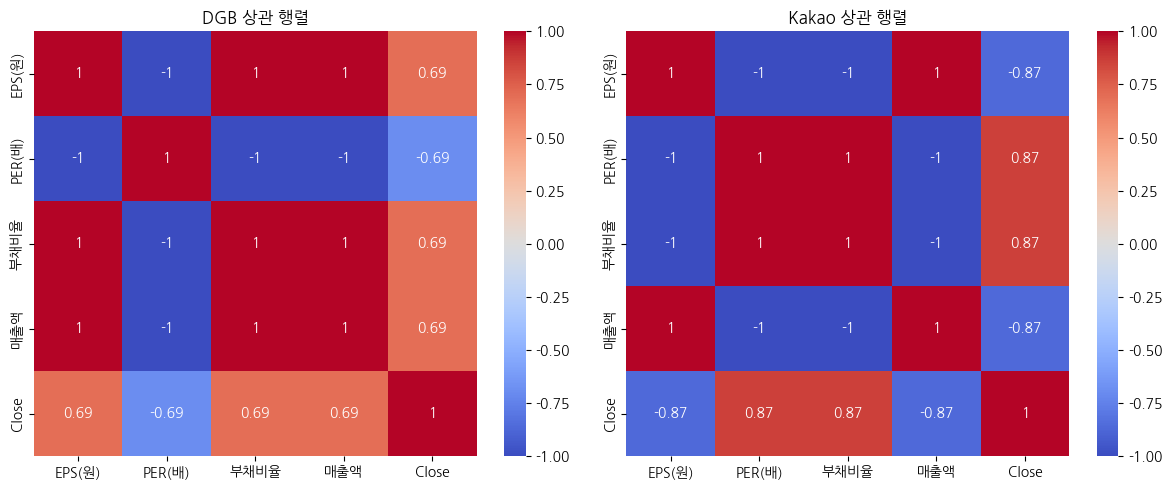

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 준비
# 주가 및 재무 지표를 포함한 DataFrame에서 주가 관련 열과 주요 재무 지표만 선택
financial_metrics = ['EPS(원)', 'PER(배)', '부채비율', '매출액']
dgb_data = dgb_df[financial_metrics + ['Close']]
kakao_data = kakao_df[financial_metrics + ['Close']]

# 상관관계 분석
print("DGB 상관관계 분석")
print(dgb_data.corr())
print("\nKakao 상관관계 분석")
print(kakao_data.corr())

# 시각화: 상관 행렬
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(dgb_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('DGB 상관 행렬')

plt.subplot(1, 2, 2)
sns.heatmap(kakao_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Kakao 상관 행렬')

plt.tight_layout()
plt.show()


In [ ]:
def perform_regression(df, independent_vars, dependent_var='Close'):
    X = df[independent_vars].dropna()
    y = df[dependent_var].loc[X.index]
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    
    print(f"회귀 분석 결과 (종속 변수: {dependent_var})")
    print(f"회귀 계수: {model.coef_}")
    print(f"절편: {model.intercept_}")
    print(f"R^2 점수: {r2_score(y, y_pred)}")
    print(f"평균 제곱 오차 (MSE): {mean_squared_error(y, y_pred)}\n")
    

# 회귀 분석 실행 (DGB 및 Kakao)
independent_vars = ['EPS(원)', 'PER(배)', '부채비율', '매출액']
perform_regression(dgb_data, independent_vars)
perform_regression(kakao_data, independent_vars)

회귀 분석 결과 (종속 변수: Close)
회귀 계수: [ 7.62489800e+12 -1.60795120e+10  1.67071188e+12 -3.05494629e+12]
절편: 5.527508014164027e+16
R^2 점수: 0.4728246836826141
평균 제곱 오차 (MSE): 115535.23966942148

회귀 분석 결과 (종속 변수: Close)
회귀 계수: [ 1.83098687e+11 -7.26200801e+10 -6.57819826e+11 -7.15205809e+10]
절편: 1052937845727972.0
R^2 점수: 0.7492212127236664
평균 제곱 오차 (MSE): 2113053.223269628



## DGB 변수중요도

DGB 변수 중요도:
EPS(원)    7.624898e+12
매출액       3.054946e+12
부채비율      1.670712e+12
PER(배)    1.607951e+10
dtype: float64


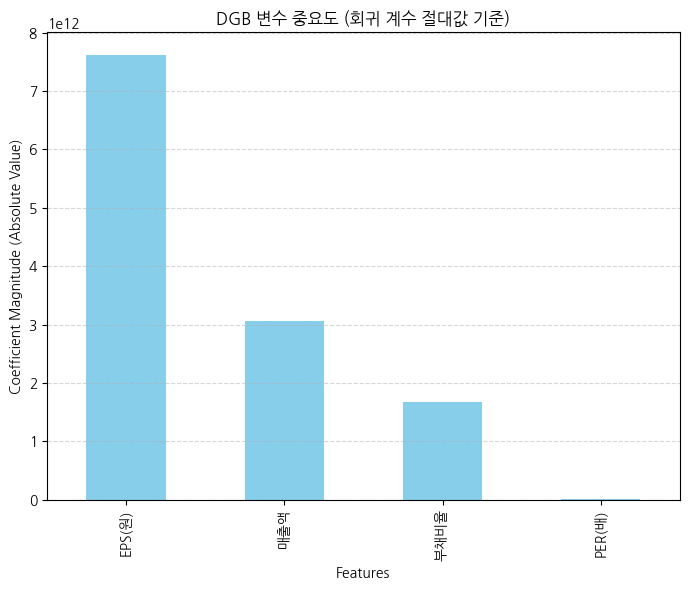

In [125]:
def plot_feature_importance(df, independent_vars, dependent_var='Close'):
    X = df[independent_vars].dropna()
    y = df[dependent_var].loc[X.index]
    
    model = LinearRegression()
    model.fit(X, y)
    
    # 회귀 계수 가져오기
    coefficients = model.coef_
    importance_df = pd.Series(data=coefficients, index=independent_vars).abs().sort_values(ascending=False)
    
    # 변수 중요도 출력 및 시각화
    print("DGB 변수 중요도:")
    print(importance_df)
    
    # 시각화
    importance_df.plot(kind='bar', figsize=(7, 6), color='skyblue')
    plt.title('DGB 변수 중요도 (회귀 계수 절대값 기준)')
    plt.ylabel('Coefficient Magnitude (Absolute Value)')
    plt.xlabel('Features')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 변수 중요도 시각화 실행
plot_feature_importance(dgb_data, independent_vars)